# Задача 9. Hand-crafted graph features

* **Дедлайн**: 16.05.2025, 23:59
* Основной полный балл: 5
* Максимум баллов: 10


## Задача

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.


**Выполнил**: Азим Мурадов

**Университет**: СПбГУ

**Группа**: 22.Б11-мм

В качестве датасета будет использован **MUTAG** датасет. Это классический датасет для задач бинарной классификации графов, содержащий информацию о химических соединениях.

- **Тип графов**: неориентированные графы молекул
- **Вершины**: атомы (без атомов водорода)
- **Рёбра**: химические связи между атомами
- **Метки графов (классы)**:
    - +1 — мутагенное соединение (может вызывать мутации ДНК)
    - -1 — не мутагенное
- **Кол-во графов**: 188
- **Средний кол-во вершин**: \~17.93 вершин
- **Средний кол-во рёбер**: \~19.79 рёбер

**Источник**:

- Датасет входит в TUDataset Collection: https://chrsmrrs.github.io/datasets/
- Cсылка на архив датасета: https://chrsmrrs.github.io/datasets/MUTAG.zip
- Первоначальная публикация:
_Debnath et al., “Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds”, Journal of Chemical Information and Computer Sciences, 1991._

In [1]:
import os

import networkx as nx


def load_and_prepare_mutag_dataset() -> tuple[list[nx.Graph], list[int]]:
    dir_path = "../data/MUTAG/"

    with open(os.path.join(dir_path, "MUTAG_graph_labels.txt")) as f:
        y = [int(line.strip()) for line in f]

    with open(os.path.join(dir_path, "MUTAG_graph_indicator.txt")) as f:
        graph_indicators = [int(line.strip()) for line in f]

    with open(os.path.join(dir_path, "MUTAG_A.txt")) as f:
        edges = [tuple(map(lambda x: int(x) - 1, line.strip().split(","))) for line in f]

    num_graphs = len(y)

    graphs = [nx.Graph() for _ in range(num_graphs)]

    for node_id, graph_id in enumerate(graph_indicators):
        graphs[graph_id - 1].add_node(node_id)

    for u, v in edges:
        g_id = graph_indicators[u] - 1
        graphs[g_id].add_edge(u, v)

    return graphs, y

In [2]:
from sklearn.model_selection import train_test_split

graphs, y = load_and_prepare_mutag_dataset()
X_train, X_test, y_train, y_test = train_test_split(graphs, y, test_size=0.3, random_state=42)

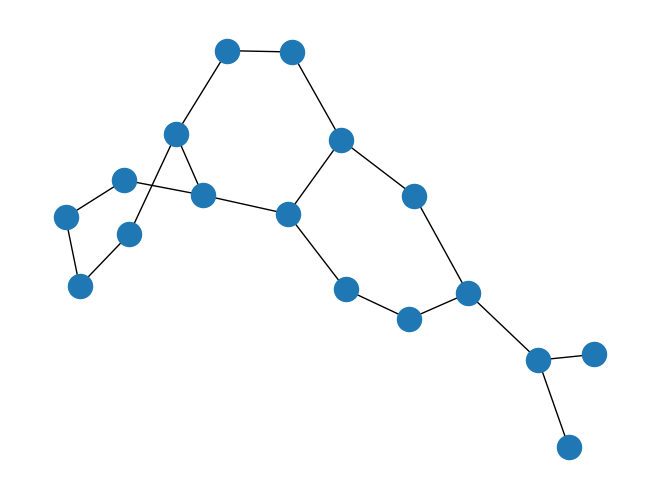

In [3]:
nx.draw(graphs[0])

## Реализуем Shortest Path Kernel

In [4]:
import numpy as np


def shortest_path_kernel(train_graphs: list[nx.Graph], test_graphs: list[nx.Graph]) -> tuple[np.ndarray, np.ndarray]:
    vec_size = len(max(train_graphs + test_graphs, key=len))

    def calc_sp_vec(g: nx.Graph) -> np.ndarray:
        sp_vec = np.zeros((vec_size,), dtype=int)
        for u, targets in nx.shortest_path_length(g):
            for v, dist in targets.items():
                if u < v:
                    sp_vec[dist] += 1
        return sp_vec

    def compute_kernel_matrix(graphs1: list[nx.Graph], graphs2: list[nx.Graph]) -> np.ndarray:
        vecs1 = np.array([calc_sp_vec(g) for g in graphs1])
        vecs2 = np.array([calc_sp_vec(g) for g in graphs2])
        return vecs1 @ vecs2.T

    K_train = compute_kernel_matrix(train_graphs, train_graphs)
    K_test = compute_kernel_matrix(test_graphs, train_graphs)

    return K_train, K_test

## Обучим модель SVC с помощью SP Kernel, подберём гиперпараметры, вычислим различные метрики качества

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

K_train_sp, K_test_sp = shortest_path_kernel(X_train, X_test)

svc_sp = GridSearchCV(
    SVC(kernel='precomputed', random_state=42),
    param_grid={'C': [0.1, 0.25, 0.5, 1, 5, 10]},
    cv=5,
)
svc_sp.fit(K_train_sp, y_train)

print("best score: ", svc_sp.best_score_)
print("best param: ", svc_sp.best_params_)

y_pred_sp = svc_sp.predict(K_test_sp)

print("=== Shortest Path Kernel ===")
print(classification_report(y_test, y_pred_sp))

best score:  0.8313390313390313
best param:  {'C': 0.25}
=== Shortest Path Kernel ===
              precision    recall  f1-score   support

          -1       0.89      0.89      0.89        18
           1       0.95      0.95      0.95        39

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57



In [6]:
y_pred_sp = svc_sp.predict(K_test_sp)

print("=== Shortest Path Kernel ===")
print(classification_report(y_test, y_pred_sp))

=== Shortest Path Kernel ===
              precision    recall  f1-score   support

          -1       0.89      0.89      0.89        18
           1       0.95      0.95      0.95        39

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57



## Реализуем Weisfeiler-Lehman Kernel

In [7]:
from collections import Counter


def weisfeiler_lehman_kernel(train_graphs: list[nx.Graph], test_graphs: list[nx.Graph], k: int = 3) -> tuple[
    np.ndarray, np.ndarray]:
    def calc_wl_features(graphs):
        features = []
        for g in graphs:
            curr_labels = {n: '0' for n in g.nodes()}
            all_labels = Counter(curr_labels.values())
            for _ in range(k):
                next_labels = {}
                for node in g.nodes():
                    neighbors = sorted([curr_labels[neighbor] for neighbor in g.neighbors(node)])
                    next_labels[node] = curr_labels[node] + "_" + "_".join(neighbors)
                curr_labels = {node: str(hash(l)) for node, l in next_labels.items()}
                all_labels.update(curr_labels.values())
            features.append(all_labels)
        return features

    train_features = calc_wl_features(train_graphs)
    test_features = calc_wl_features(test_graphs)

    all_keys = list(set(key for f in (train_features + test_features) for key in f))
    enumerated_keys = {key: i for i, key in enumerate(all_keys)}

    def compute_feature_matrix(features1, features2):
        vecs1 = np.zeros((len(features1), len(all_keys)), dtype=int)
        vecs2 = np.zeros((len(features2), len(all_keys)), dtype=int)

        for i, f in enumerate(features1):
            for key, cnt in f.items():
                vecs1[i, enumerated_keys[key]] = cnt
        for i, f in enumerate(features2):
            for key, cnt in f.items():
                vecs2[i, enumerated_keys[key]] = cnt

        return vecs1 @ vecs2.T

    K_train = compute_feature_matrix(train_features, train_features)
    K_test = compute_feature_matrix(test_features, train_features)

    return K_train, K_test

## Обучим модель SVC с помощью WL Kernel и сравним модели

In [8]:
K_train_wl, K_test_wl = weisfeiler_lehman_kernel(X_train, X_test)

svc_wl = GridSearchCV(
    SVC(kernel='precomputed', random_state=42),
    param_grid={'C': [0.1, 0.25, 0.5, 1, 5, 10]},
    cv=5,
)
svc_wl.fit(K_train_wl, y_train)

print("best score: ", svc_wl.best_score_)
print("best param: ", svc_wl.best_params_)

y_pred_wl = svc_wl.predict(K_test_wl)

print("=== Shortest Path Kernel ===")
print(classification_report(y_test, y_pred_sp))

print("=== Weisfeiler-Lehman Kernel ===")
print(classification_report(y_test, y_pred_wl))

best score:  0.7934472934472934
best param:  {'C': 0.1}
=== Shortest Path Kernel ===
              precision    recall  f1-score   support

          -1       0.89      0.89      0.89        18
           1       0.95      0.95      0.95        39

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57

=== Weisfeiler-Lehman Kernel ===
              precision    recall  f1-score   support

          -1       0.94      0.83      0.88        18
           1       0.93      0.97      0.95        39

    accuracy                           0.93        57
   macro avg       0.93      0.90      0.92        57
weighted avg       0.93      0.93      0.93        57

